# Validation
to make every wine accessible, we train the model again on the full dataset

In [1]:
from IPython.display import display, clear_output
import os
import seaborn as sns
import numpy as np
from importlib import reload
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from wine_and_cheese_utils import WineList, df_columns, regexp_tokenizer

%matplotlib inline

import warnings
    
warnings.filterwarnings("ignore")

## Import the data in a WineList object

In [ ]:
wl = WineList(file='cleaned')
# wl.add_region_variety_stop_words()
# create and store the TaggedDocument list
wl.get_tagged_data()
# import (or retrain) the Doc2Vec model
wl.get_doc2vec_model()

In [270]:
# Top 10 words most similar to 'simple'
wl.model.most_similar('simple',topn=10)

[('informal', 0.7125917673110962),
 ('fuss', 0.6947001218795776),
 ('easygoing', 0.6764289736747742),
 ('direct', 0.6641587018966675),
 ('casual', 0.6553080081939697),
 ('straightforward', 0.6512728333473206),
 ('charming', 0.6423518657684326),
 ('quaffer', 0.6385226249694824),
 ('nondescript', 0.6279109716415405),
 ('genuine', 0.6259700059890747)]

In [191]:
# Top 10 words most similar to 'smooth'
wl.model.most_similar('smooth',topn=10)

[('soft', 0.7097400426864624),
 ('supple', 0.686550498008728),
 ('satiny', 0.6736397743225098),
 ('round', 0.6655285358428955),
 ('velvety', 0.6583887338638306),
 ('accessible', 0.6254149675369263),
 ('firm', 0.6122607588768005),
 ('soothing', 0.6078168749809265),
 ('glossy', 0.6072683334350586),
 ('network', 0.6060467958450317)]

In [190]:
# Top 10 words most similar to 'lemon'
wl.model.most_similar('lemon',topn=10)

[('curd', 0.8583096265792847),
 ('tangerine', 0.8469404578208923),
 ('lime', 0.8356151580810547),
 ('grapefruit', 0.8181753754615784),
 ('pith', 0.8137401342391968),
 ('pomelo', 0.8118531703948975),
 ('apple', 0.8017528653144836),
 ('pear', 0.8008025884628296),
 ('gravenstein', 0.797846257686615),
 ('peels', 0.7893885374069214)]

In [3]:
# we evaluate the model on regions
column_name = 'region_1'
# count the number of wines in the DataFrame for each region
wl.get_column_cnt_list(column_name)

(1, 10000)

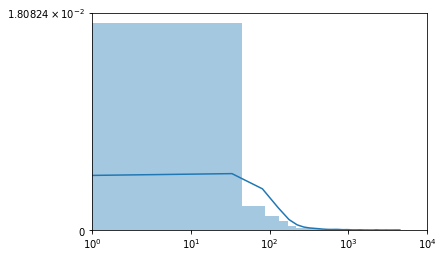

In [4]:
# distribution of wine occurences
sns.distplot([x['count'] for x in wl.column_cnt[column_name]],bins=100)
plt.xscale('symlog')
plt.yscale('symlog')
plt.xlim([1,10000])

In [199]:
# let's not consider wine regions or varieties that have less than 50 wines
n_min=50
# get the list of regions with more than n_min wines in the DataFrame
top_regions_list = wl.get_top_keys('region_1',n_min=n_min)
# top_region_list = [x for x in top_regions]

top_varieties_list = wl.get_top_keys('variety',n_min=50)

In [6]:
# Evaluate how close (cosine) 2 wines from the same region
# within_variety_cosines = []
within_region_cosines = []
random_cosines = []
n_sample = 3000
for n in range(0,n_sample):
    region = random.choice(top_regions_list)
    region_wines = wl.df[wl.df.region_1==region['name']]
    d1,d2 = [row.Index for row in region_wines.sample(n=2).itertuples()]
    within_region_cosines.append(wl.model.docvecs.similarity(d1,d2))
    
#     variety = random.choice(top_varieties_list)
#     variety_wines = wl.df[wl.df.variety==variety['name']]
#     d1,d2 = [row.Index for row in variety_wines.sample(n=2).itertuples()]
#     within_variety_cosines.append(wl.model.docvecs.similarity(d1,d2))    
    
    d1,d2 = [row.Index for row in wl.df.sample(n=2).itertuples()]
    random_cosines.append(wl.model.docvecs.similarity(d1,d2))
    

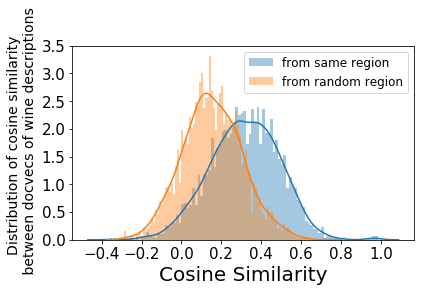

In [207]:
sns.distplot(within_region_cosines,bins=100)
# sns.distplot(within_variety_cosines,bins=100)
sns.distplot(random_cosines,bins=100)
# plt.xlim([0.95,1])
plt.xlabel('Cosine Similarity', fontsize=20)
plt.xticks(fontsize=15)
# plt.title('Wines from the same region have higher \n cosine similarity than wine from random regions', fontsize=14)
plt.ylabel('Distribution of cosine similarity \n between docvecs of wine descriptions', fontsize=14)
plt.yticks(fontsize=15)
plt.legend(['from same region','from random region'], fontsize=12)
plt.ylim([0,3.5])
plt.tight_layout()
plt.savefig('figures/within_across_regions.pdf')
plt.savefig('figures/within_across_regions.png')

## Mean feature vector for each 'top' region
For each region that has more than n_min wines, we compute the mean feature vector.
To save computing time, we'll use only a subset of wines from a region to compute its average wine.
We'll set a threshold to decide whether the average computation is converging.

It turns out that the 'infer_vector' method used to compute a feature vector from a tokenized description provide a non-deterministic results.

Text(0.5, 0, 'Cosine Similarities')

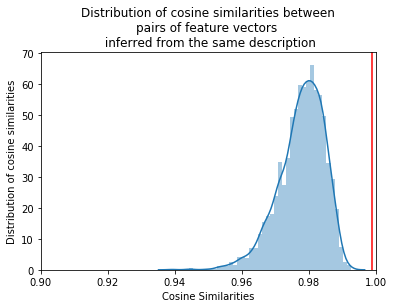

In [161]:
yup = []

for n in range(0,3000):
    desc = wl.tokenize(wl.df.sample(n=1).description.values[0])
    v0 = wl.model.infer_vector(desc).reshape(1,-1)
    v1 = wl.model.infer_vector(desc).reshape(1,-1)
    yup.append(cosine_similarity(v0,v1))

dp_object = sns.distplot(yup)
np.max(dp_object.get_lines()[0].get_data())
y_max = np.max(dp_object.get_lines()[0].get_data())*1.15
plt.xlim([0.9,1])
plt.vlines(0.999,ymin=0,ymax=y_max,color='r')
plt.ylim([0,y_max])
plt.title("Distribution of cosine similarities between\npairs of feature vectors \n inferred from the same description")
plt.ylabel("Distribution of cosine similarities")
plt.xlabel("Cosine Similarities")


In [166]:
# Seems like 0.9999 is a VERY conservative threshold
cosine_similarity_threshold = 0.9999
# initialize a dictionary to store the mean vector for each region
mean_vects_dict = dict.fromkeys([x['name'] for x in top_regions_list],np.zeros(40,))
# for every region in the list
for region in top_regions_list:
    # get the rows for wines of that region
    region_df = wl.df[wl.df.region_1==region['name']]
    # shuffle the filtered DataFrame wines
    region_df = region_df.sample(frac=1)
    # initialize a counter
    cnt=0
    # and a "previous vector"
    prev_vec = np.ones(40,).reshape(1, -1)
    keepgoing = True

    for row in region_df.itertuples():
        if keepgoing:
            cnt+=1
            # infer the feature vector
            new_vec = wl.model.infer_vector(wl.tokenize(row.description)).reshape(1, -1)
            # update the mean vector
            mean_vects_dict[region['name']] = ((cnt-1)*mean_vects_dict[region['name']]+new_vec)/cnt
            # update the previous vector
            prev_vec = mean_vects_dict[region['name']]
            # test if we reached the threshold for the convergence of the mean vector
            keepgoing = cosine_similarity(prev_vec,mean_vects_dict[region['name']])<cosine_similarity_threshold        
        else:
            break

In [167]:
# concatenate all the mean vectors into an array
cat_mean_vects = np.concatenate(list(mean_vects_dict.values()),axis=0)

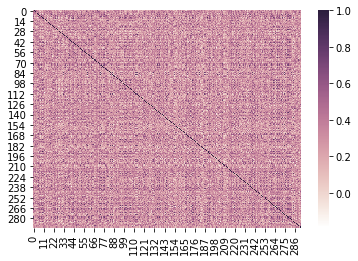

In [168]:
# concatenate all the mean vectors into an array
sim_mat = cosine_similarity(cat_mean_vects)
# let's look at it
sns.heatmap(sim_mat,cmap=sns.cubehelix_palette(light=1, as_cmap=True))

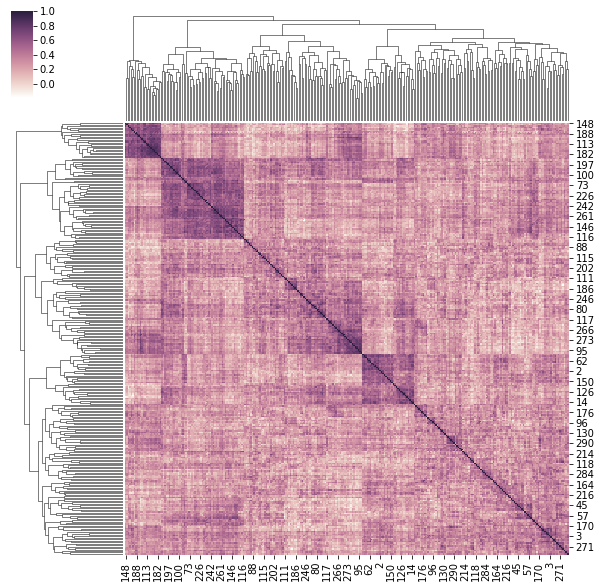

In [169]:
# apply clustermap to see if there is some structure
cg = sns.clustermap(sim_mat,cmap=sns.cubehelix_palette(light=1, as_cmap=True))

## Some regions are more similar than others
Looking at the lowest (resp. highest) values that are not on the diagonal to find pairs of regions that are the most different (resp. similar)

In [170]:
# copy the reordered array
zd_ordered_sim_mat = np.copy(cg.data2d.values)
# set the diagonal values to zero
np.fill_diagonal(zd_ordered_sim_mat,0)

In [171]:
def get_closest_to_average_description(region_1,topn=30):
    """
        a function to display the wine from a region most similar to the average feature vector of that region
    """
    mean_vect = np.array(mean_vects_dict[region_1])
    # find the most similar docsvec for its mean vector
    similar_docs = wl.model.docvecs.most_similar(mean_vect,topn=topn)
    keepgoing = True
    indx = -1
    return_str = "Sorry, we couldn't find anything, consider increasing 'topn'"
    while keepgoing:
        indx+=1
        if wl.df.loc[similar_docs[indx][0]].region_1==region_1:
            keepgoing=False
            return_str = wl.df.loc[similar_docs[indx][0]].description
    print("The closest to average '" + region_1 + "':\n" + return_str)
        

## Sorting pair of wine regions from least to most similar

In [177]:
# indexes of the highest off-diagonal pairs (most similar regions)
ind = np.unravel_index(np.argsort(zd_ordered_sim_mat, axis=None),zd_ordered_sim_mat.shape)
pairs = [[x,y] for x,y in zip(ind[0],ind[1])]
pairs = pairs[::2]

print("A few pairs of very different wines:\n")
for pair in pairs[:5]:
    first_region = top_regions_list[cg.dendrogram_row.reordered_ind[pair[0]]]['name']
    second_region = top_regions_list[cg.dendrogram_row.reordered_ind[pair[1]]]['name']
    print("{} / {}".format(first_region,second_region))
    
print("\n\nA few pairs of very similar wines:\n")
for pair in pairs[-5:]:
    first_region = top_regions_list[cg.dendrogram_row.reordered_ind[pair[0]]]['name']
    second_region = top_regions_list[cg.dendrogram_row.reordered_ind[pair[1]]]['name']
    print("{} / {}".format(first_region,second_region))

A few pairs of very different wines:

Cayuga Lake / Fleurie
Valdeorras / Bolgheri Superiore
Arroyo Seco / Rockpile
Red Hills Lake County / Côtes du Rhône
Rattlesnake Hills / Happy Canyon of Santa Barbara


A few pairs of very similar wines:

Mâcon-Villages / Vin de France
Sicilia / Verdicchio dei Castelli di Jesi Classico
Montefalco Sagrantino / Romagna
Chianti Rufina / Montefalco Rosso
Valdobbiadene Prosecco Superiore / Conegliano Valdobbiadene Prosecco Superiore


## Most different wine regions

In [186]:
# corresponding regions
region_0 = top_regions_list[cg.dendrogram_row.reordered_ind[pairs[0][0]]]['name']
region_1 = top_regions_list[cg.dendrogram_row.reordered_ind[pairs[0][1]]]['name']
print("Wines from '{}' and '{}' are predicted to be very different".format(region_0,region_1))
print(" ")
print("Here are two descriptions:")
get_closest_to_average_description(region_0)
print(" ")
get_closest_to_average_description(region_1)

Wines from 'Cayuga Lake' and 'Fleurie' are predicted to be very different
 
Here are two descriptions:
The closest to average 'Cayuga Lake':
Refreshing on the palate with a fresh apple aroma and juicy pink grapefruits on the palate, this medium-bodied Gewürztraminer is an easy-drinking, eminently quaffable wine. Off-dry like a brisk, honey-sweetened iced tea, it finishes with a pleasant kick of spice and potpourri.
 
The closest to average 'Fleurie':
One of a series of single parcel wines from the Chermette family estate, this is dark and rich. It has generous tannins alongside the dark cherry and plum fruit. The cru wine's structure and richness will allow it to age. Drink from 2018.


## Most similar wine regions

In [184]:
# indexes of the highest off-diagonal pairs (most similar regions)
# ind = np.unravel_index(np.argmax(zd_ordered_sim_mat, axis=None),zd_ordered_sim_mat.shape)
# corresponding regions
region_0 = top_regions_list[cg.dendrogram_row.reordered_ind[pairs[-2][0]]]['name']
region_1 = top_regions_list[cg.dendrogram_row.reordered_ind[pairs[-2][1]]]['name']
print("Wines from '{}' and '{}' are predicted to be very similar".format(region_0,region_1))
print(" ")
print("Here are two descriptions:")     
get_closest_to_average_description(region_0)
print(" ")
get_closest_to_average_description(region_1)

Wines from 'Chianti Rufina' and 'Montefalco Rosso' are predicted to be very similar
 
Here are two descriptions:
The closest to average 'Chianti Rufina':
Sleek and fresh, this vibrant wine opens with aromas of dark berry, leafy underbrush, grilled porcini mushrooms and a whiff of tilled soil. The savory palate doles out juicy black cherry, clove, dried herb and anise alongside bright acidity and polished tannins. Drink through 2017.
 
The closest to average 'Montefalco Rosso':
Blue flower, tilled soil, spicy plum and grilled herb aromas lead the nose on this medium-bodied, elegant wine. The vibrant, savory palate delivers crushed black cherry, mature blackberry, clove and thyme alongside firm but fine-grained tannins. Drink through 2018.


# Low dimensional representation of these regions
Each of these regions have many different wines. Let's see if the wine in these regions have very different distributions

In [229]:
region_names = [region['name'] for region in top_regions_list]
regions_df = wl.df[wl.df.region_1.isin([region['name'] for region in top_regions_list])]
regions_docvecs = []
# indexes = {region:[] for region in region_names}
indexes = []
mat_index=-1
names = []

## PCA on feature vectors

In [230]:
for _, row in regions_df.iterrows():
    if names.count(row.region_1)<n_min:
        mat_index+=1
        # indexes[row.region_1].append(mat_index)
        indexes.append(mat_index)
        names.append(row.region_1)
        regions_docvecs.append(wl.model.infer_vector(row.description))

In [231]:
regions_docvecs = np.array(regions_docvecs)


Text(0, 0.5, 'Cumulative Variance Ratio for N first PC')

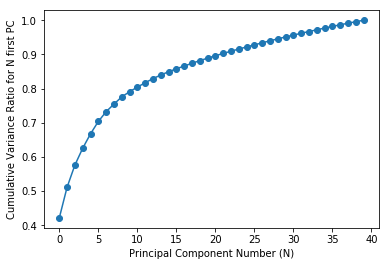

In [232]:
pca = PCA(n_components=40)
pca.fit(regions_docvecs)
PCA(copy=True, iterated_power='auto', random_state=None,svd_solver='auto', tol=0.0, whiten=False)
y = pca.transform(regions_docvecs)
plt.plot(np.cumsum(pca.explained_variance_ratio_),'o-')
plt.xlabel('Principal Component Number (N)')
plt.ylabel('Cumulative Variance Ratio for N first PC')

In [260]:
# wine region that is the most different from 'Chianti Rufina'
for pair in pairs:
    if pair[1]==pairs[-2][0]:
        print(top_regions_list[cg.dendrogram_row.reordered_ind[pair[0]]]['name'])
        break


Green Valley


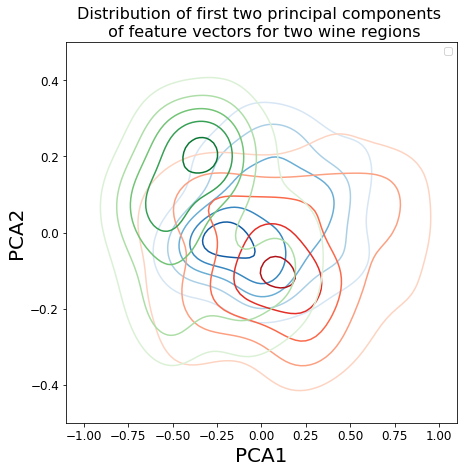

In [266]:
df_regions = pd.DataFrame(columns=["PCA1","PCA2","name"])
df_regions.PCA1 = y[:,0]
df_regions.PCA2 = y[:,1]
df_regions.name = names
df_regions.head()

# similar:{'Chianti Rufina':"Blues",'Montefalco Rosso':"Reds"}
# different:{'Cayuga Lake':"Blues",'Fleurie':"Reds"}
# plot_regions_dict = {'Chianti Rufina':"Blues",'Montefalco Rosso':"Reds",'Fleurie':"Greens"}
# 'Mendoza','Côtes de Provence','Barolo'
plot_regions_dict = {'Mendoza':"Blues",'Côtes de Provence':"Reds",'Barolo':"Greens"}

these_regions_list = list(plot_regions_dict.keys())
fig = plt.figure(figsize=(7, 7))

for plot_region in plot_regions_dict.keys():
    sub_df = df_regions[df_regions.name.str.match(plot_region)]
    ax = sns.kdeplot(sub_df.PCA1,sub_df.PCA2,n_levels=5,cmap=plot_regions_dict[plot_region])


plt.ylabel("PCA2",fontdict={"size":20})
plt.xlabel("PCA1",fontdict={"size":20})
plt.xlim([-1.1,1.1])
plt.ylim([-.5,.5])
red = sns.color_palette("Reds")[-2]
blue = sns.color_palette("Blues")[-2]
# ax.text(.1, -.4, "Côtes de Provence", size=16, color=red)
# ax.text(-.85, -.3, "Barolo", size=16, color=blue)
plt.legend(plot_regions_dict.keys())
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.tight_layout()
plt.title('Distribution of first two principal components \n of feature vectors for two wine regions',fontdict={"size":16})
plt.savefig("figures/PCA_1_2_for_two_wines_{}.pdf".format("_".join([x for x in these_regions_list])), bbox_inches = 'tight')
plt.savefig("figures/PCA_1_2_for_two_wines_{}.png".format("_".join([x for x in these_regions_list])), bbox_inches = 'tight')

## Prices distribution

Text(0.5, 0, 'log10 of price')

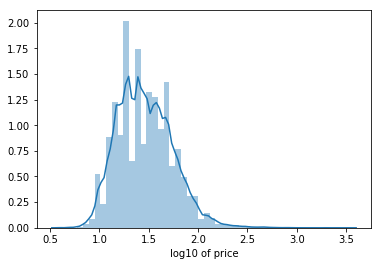

In [268]:
sns.distplot(np.log10(wl.df.price))
plt.xlabel("log10 of price")